In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm
import cv2
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,BatchNormalization,Concatenate,ReLU,LeakyReLU,Add,Activation,Input,MaxPool2D
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D,UpSampling2D

In [2]:
path = '../input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset'

In [3]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3

In [4]:
train_ids = sorted(next(os.walk(path))[1])

In [5]:
train = []
mask=[]
for n,i in tqdm(enumerate(train_ids)):
    a=os.listdir(path+'/'+i)
    i_path=path+'/'+i+'/'+a[0]
    m_path=path+'/'+i+'/'+a[1]
    a=os.listdir(i_path)
    b=os.listdir(m_path)
    for j in a:
        a=i_path+'/'+j
        c=cv2.imread(i_path+'/'+j)
        c=cv2.resize(c,(IMG_HEIGHT,IMG_WIDTH))
        train.append(c)
        b=a.replace("jpg", "png")
        b=b.replace('images','masks')
        m=cv2.imread(b)
        m=cv2.resize(m,(IMG_HEIGHT,IMG_WIDTH))
        mask.append(m)

8it [00:03,  2.51it/s]


In [6]:
mask = np.array(mask)
train = np.array(train)

In [7]:
inputs = tf.keras.layers.Input((224,224,3))

c1 = tf.keras.layers.Conv2D(32,(3,3),activation='tanh',padding='same')(inputs)
c1 = BatchNormalization()(c1)
c1 = tf.keras.layers.Conv2D(32,(3,3),activation='softplus',padding='same')(c1)
c1 = BatchNormalization()(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(64,(3,3),activation='tanh',padding='same')(p1)
c2 = BatchNormalization()(c2)
c2 = tf.keras.layers.Conv2D(64,(3,3),activation='softplus',padding='same')(c2)
c2 = BatchNormalization()(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(128,(3,3),activation='tanh',padding='same')(p2)
c3 = BatchNormalization()(c3)
c3 = tf.keras.layers.Conv2D(128,(3,3),activation='softplus',padding='same')(c3)
c3 = BatchNormalization()(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(256,(3,3),activation='tanh',padding='same')(p3)
c4 = BatchNormalization()(c4)
c4 = tf.keras.layers.Conv2D(256,(3,3),activation='softplus',padding='same')(c4)
c4 = BatchNormalization()(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(512,(3,3),activation='tanh',padding='same')(p4)
c5 = BatchNormalization()(c5)
c5 = tf.keras.layers.Conv2D(512,(3,3),activation='softplus',padding='same')(c5)
c5 = BatchNormalization()(c5)
p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

c6 = tf.keras.layers.Conv2D(1024,(3,3),activation='tanh',padding='same')(p5)
c6 = BatchNormalization()(c6)
c6 = tf.keras.layers.Conv2D(1024,(3,3),activation='softplus',padding='same')(c6)
c6 = BatchNormalization()(c6)

u7 = UpSampling2D((2, 2), interpolation="bilinear")(c6)
c7 = Concatenate()([u7, c5])
c7 = tf.keras.layers.Conv2D(512,(3,3),activation='tanh',padding='same')(c7)
c7 = BatchNormalization()(c7)
c7 = tf.keras.layers.Conv2D(512,(3,3),activation='softplus',padding='same')(c7)
c7 = BatchNormalization()(c7)

u8 = UpSampling2D((2, 2), interpolation="bilinear")(c7)
c8 = Concatenate()([u8, c4])
c8 = tf.keras.layers.Conv2D(256,(3,3),activation='tanh',padding='same')(c8)
c8 = BatchNormalization()(c8)
c8 = tf.keras.layers.Conv2D(256,(3,3),activation='softplus',padding='same')(c8)
c8 = BatchNormalization()(c8)

u9 = UpSampling2D((2, 2), interpolation="bilinear")(c8)
c9 = Concatenate()([u9, c3])
c9 = tf.keras.layers.Conv2D(128,(3,3),activation='tanh',padding='same')(c9)
c9 = BatchNormalization()(c9)
c9 = tf.keras.layers.Conv2D(128,(3,3),activation='softplus',padding='same')(c9)
c9 = BatchNormalization()(c9)

u10 = UpSampling2D((2, 2), interpolation="bilinear")(c9)
c10 = Concatenate()([u10, c2])
c10 = tf.keras.layers.Conv2D(64,(3,3),activation='tanh',padding='same')(c10)
c10 = BatchNormalization()(c10)
c10 = tf.keras.layers.Conv2D(64,(3,3),activation='softplus',padding='same')(c10)
c10 = BatchNormalization()(c10)

u11 = UpSampling2D((2, 2), interpolation="bilinear")(c10)
c11 = Concatenate()([u11, c1])
c11 = tf.keras.layers.Conv2D(32,(3,3),activation='tanh',padding='same')(c11)
c11 = BatchNormalization()(c11)
c11 = tf.keras.layers.Conv2D(32,(3,3),activation='softplus',padding='same')(c11)
c11 = BatchNormalization()(c11)

outputs = Conv2D(3, 1, padding="same", activation="softmax")(c11)
model = tf.keras.Model(inputs=[inputs],outputs=[outputs])

In [8]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [9]:
model.fit(train,mask, batch_size=5, epochs=150)

Epoch 1/150
15/15 [==============================] - 8s 128ms/step - loss: 26180.2131 - accuracy: 0.5843
Epoch 2/150
15/15 [==============================] - 1s 77ms/step - loss: 26073.2814 - accuracy: 0.8224
Epoch 3/150
15/15 [==============================] - 1s 77ms/step - loss: 26701.6428 - accuracy: 0.7750
Epoch 4/150
15/15 [==============================] - 1s 77ms/step - loss: 25924.5730 - accuracy: 0.8511
Epoch 5/150
15/15 [==============================] - 1s 79ms/step - loss: 26483.0006 - accuracy: 0.8231
Epoch 6/150
15/15 [==============================] - 1s 77ms/step - loss: 25967.7271 - accuracy: 0.8415
Epoch 7/150
15/15 [==============================] - 1s 77ms/step - loss: 26241.6324 - accuracy: 0.8811
Epoch 8/150
15/15 [==============================] - 1s 76ms/step - loss: 26286.2948 - accuracy: 0.8853
Epoch 9/150
15/15 [==============================] - 1s 77ms/step - loss: 26189.7201 - accuracy: 0.8385
Epoch 10/150
15/15 [==============================] - 1s 77ms/s

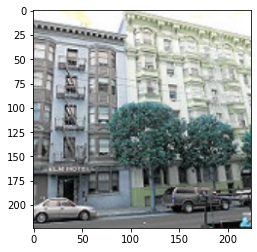

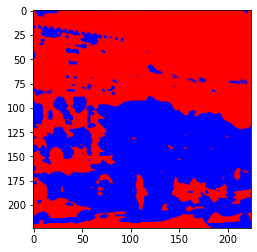

In [10]:
test_path='../input/intel-image-classification/seg_train/seg_train/buildings/10730.jpg'
test=cv2.imread(test_path)
test=cv2.resize(test,(224,224))
test1 = np.expand_dims(test,0)
tt=model.predict(test1)
tt=np.squeeze(tt)

f, axarr = plt.subplots(1,1)
plt.imshow(test)
f, axarr = plt.subplots(1,1)
plt.imshow(tt)